In [23]:
import warnings
warnings.filterwarnings('ignore')

# Interpretation by SHAP

In [ ]:
!pip install shap

In [25]:
# Convert the encoded variable to the original values for a better explanation
X_display=pd.read_csv('newTrain.csv')
X_display['rep_education'] = X_display['rep_education'].replace({0:"other"})
X_display['rep_education'] = X_display['rep_education'].replace({1:"high_school"})
X_display['rep_education'] = X_display['rep_education'].replace({2:"college"})
X_display['rep_education'] = X_display['rep_education'].replace({3:"graduate"})
del X_display['Def_ind']

In [26]:
# train XGBoost model
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

model = xgb.XGBClassifier(
    objective='reg:logistic'
)
model.fit(dftrain, y_train)
y_pred = model.predict(dfeval)
acc = accuracy_score(y_eval, y_pred.round())
print(acc, '\n')

0.9094 



In [27]:
import shap 

# create a SHAP explainer for our trained model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dftrain)

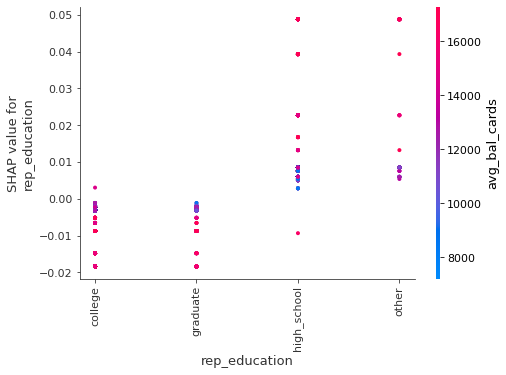

In [29]:
# SHAP depence plot for 'rep_education' and 'avg_bal_cards' variables.
shap.dependence_plot("rep_education", shap_values, X_display)

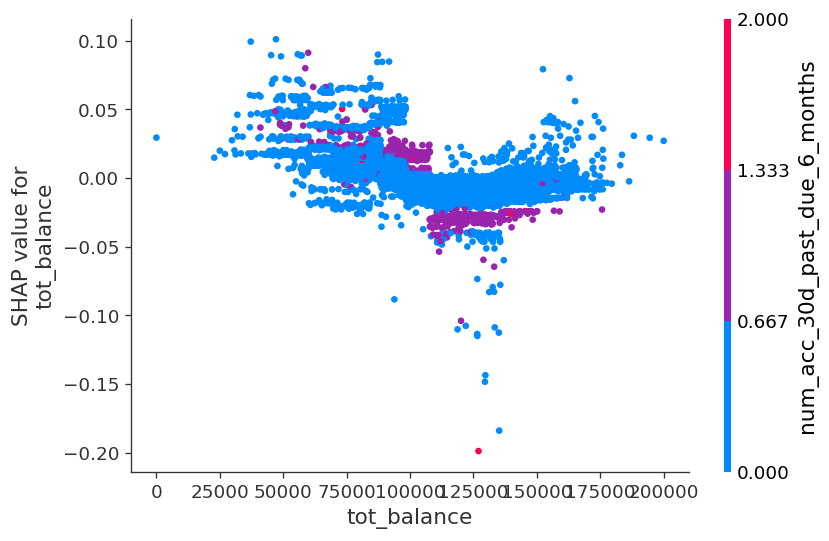

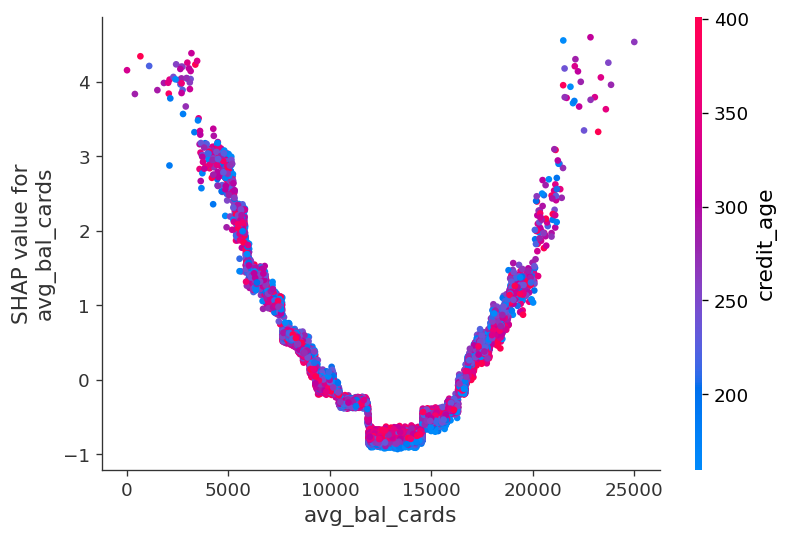

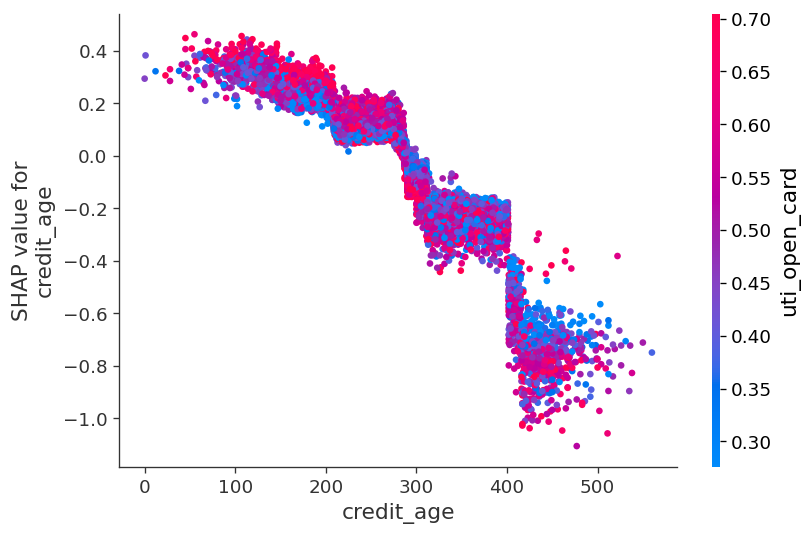

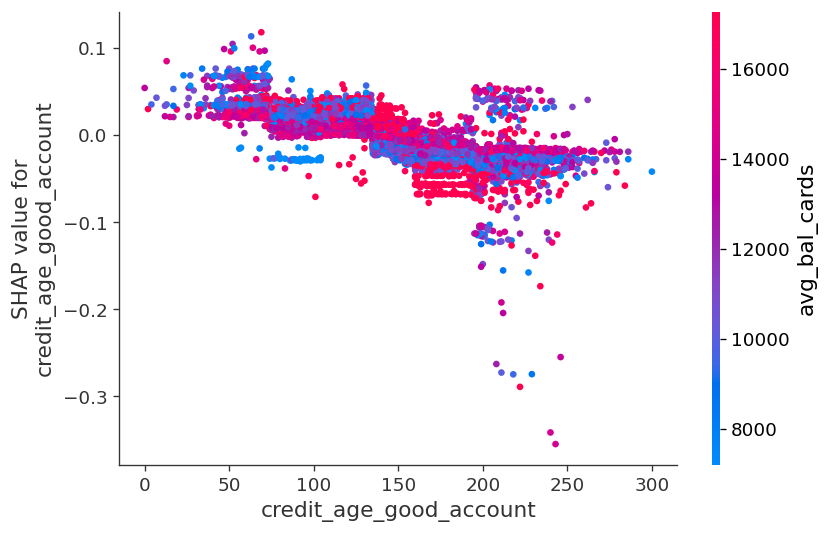

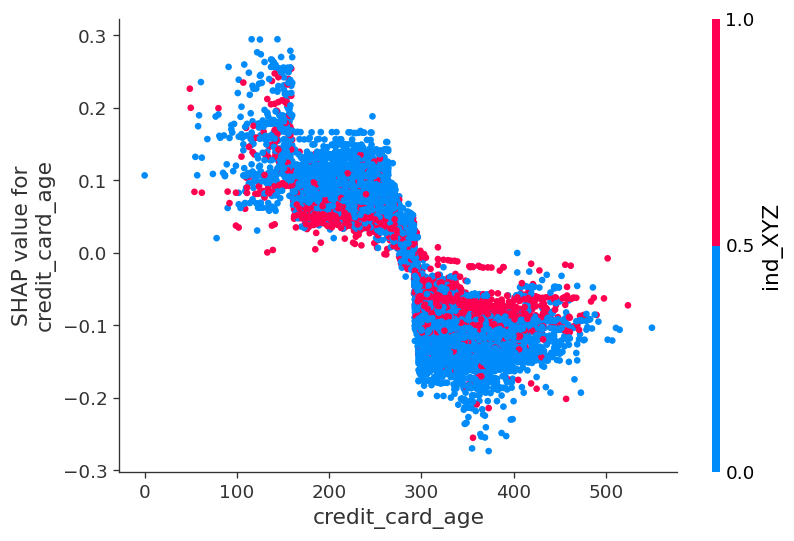

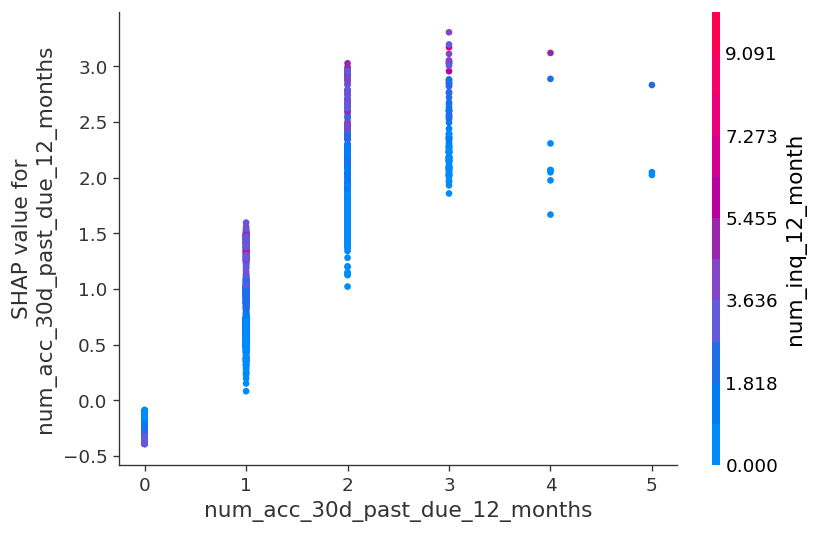

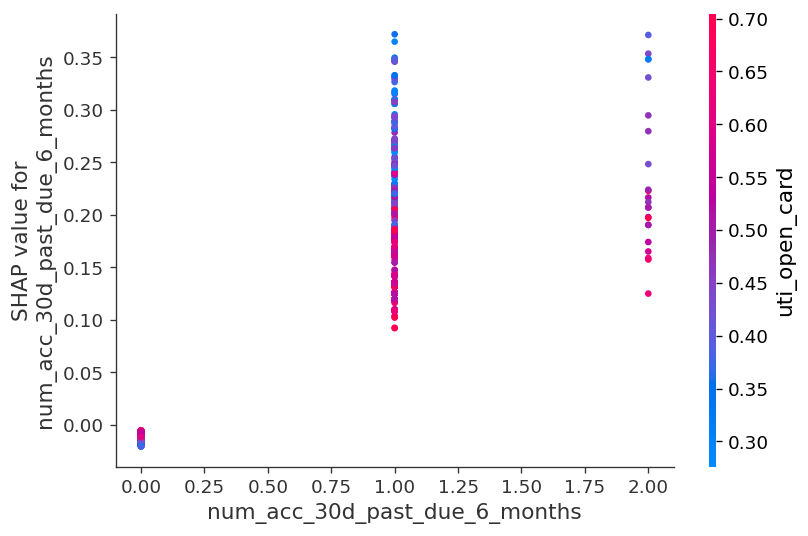

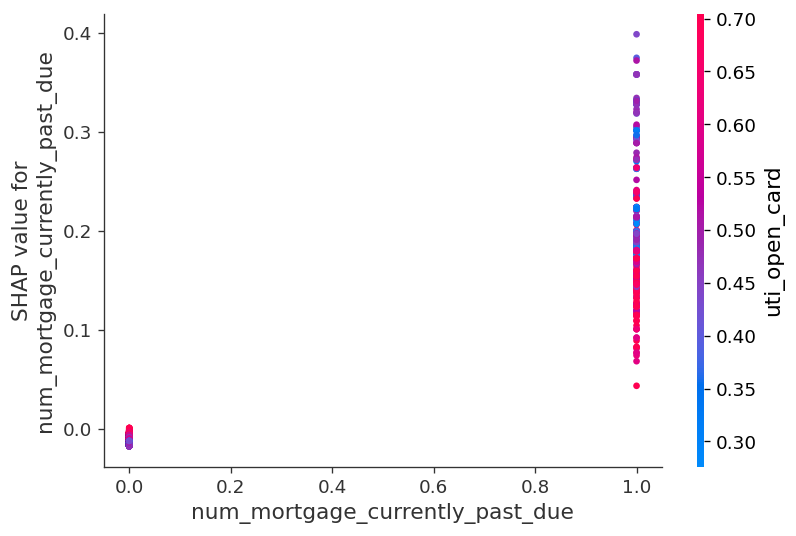

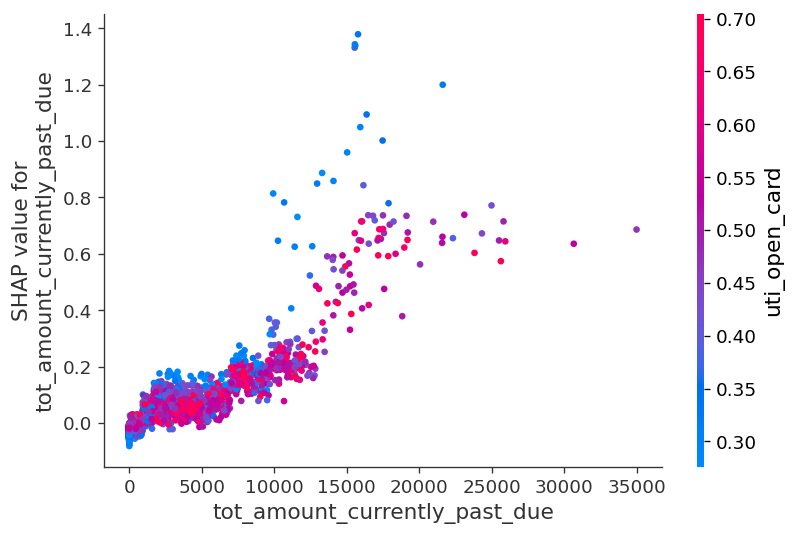

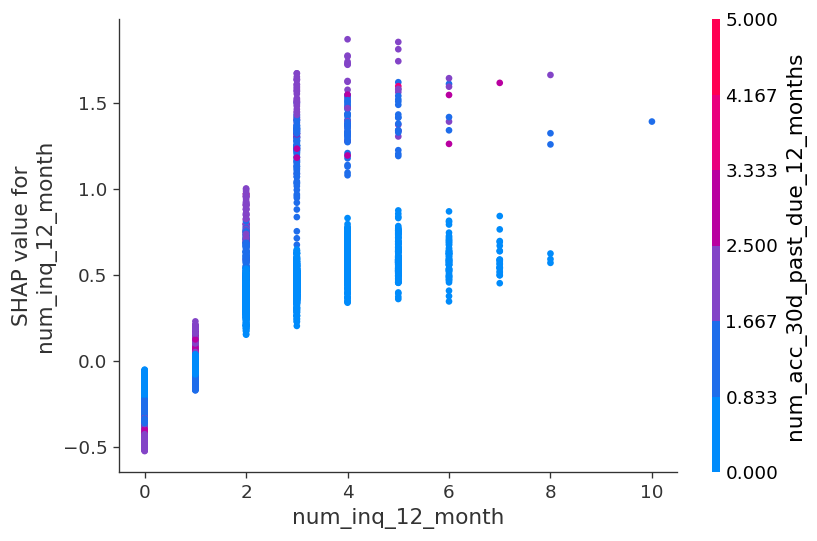

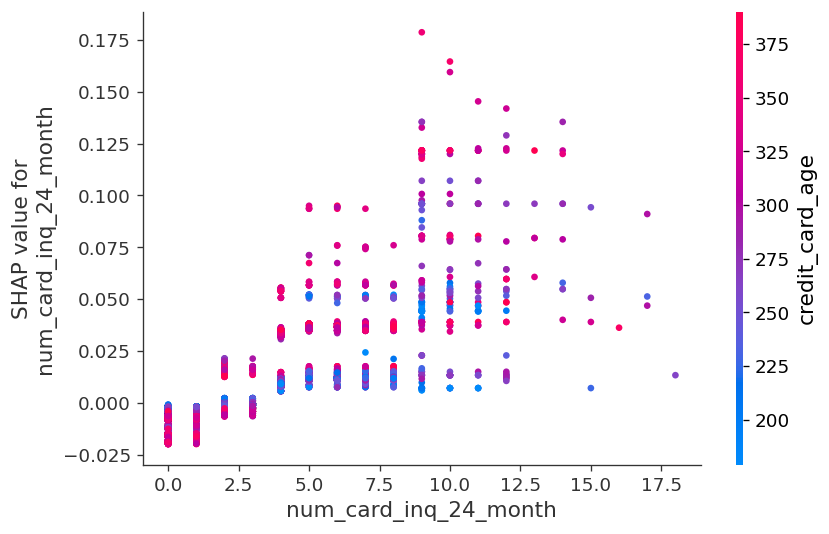

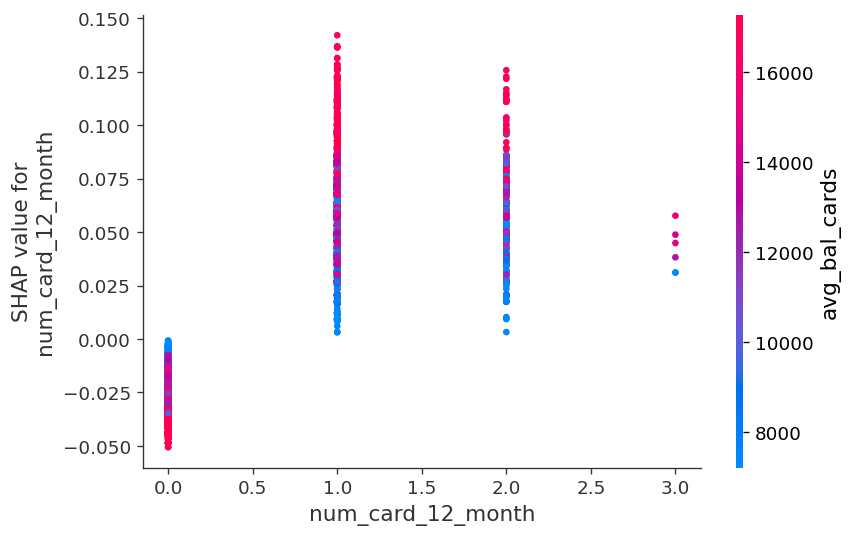

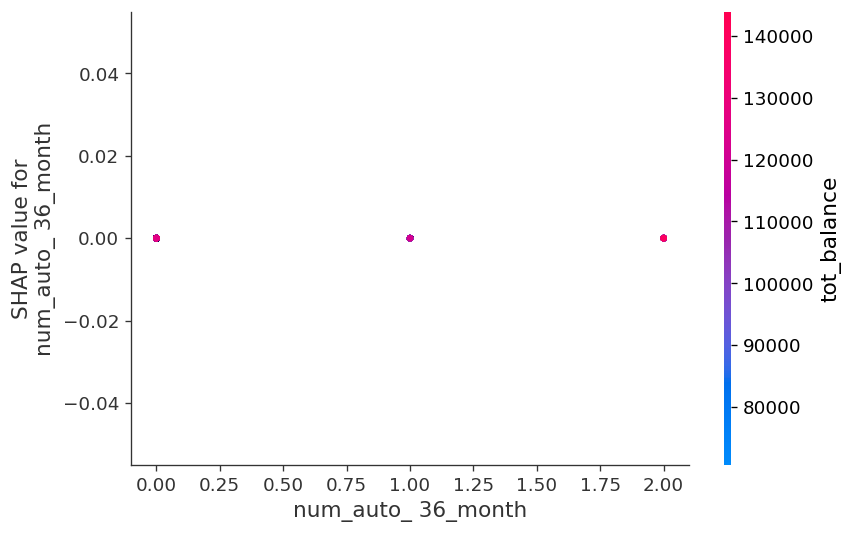

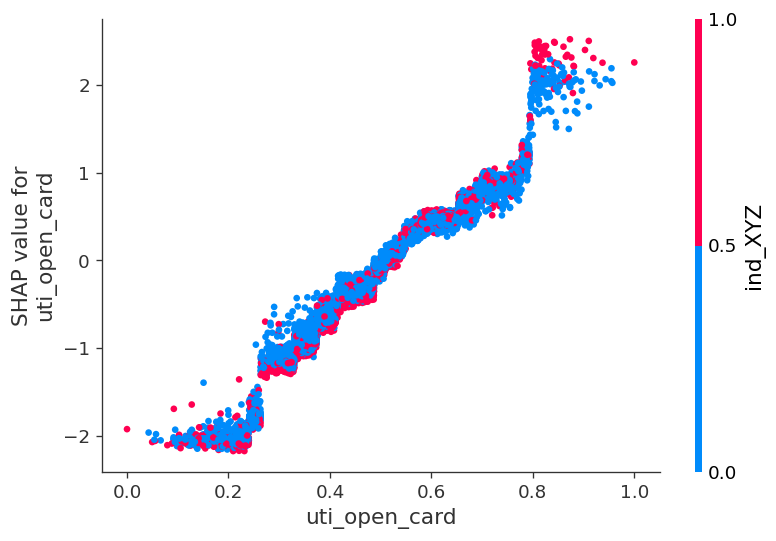

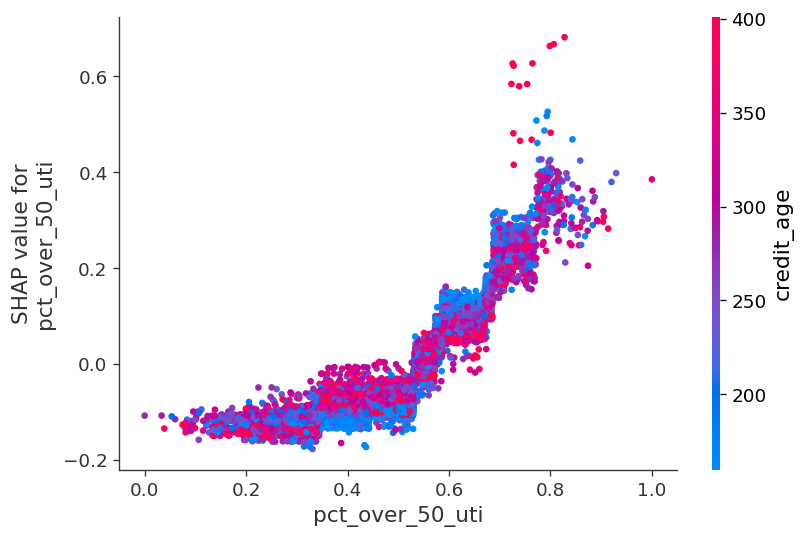

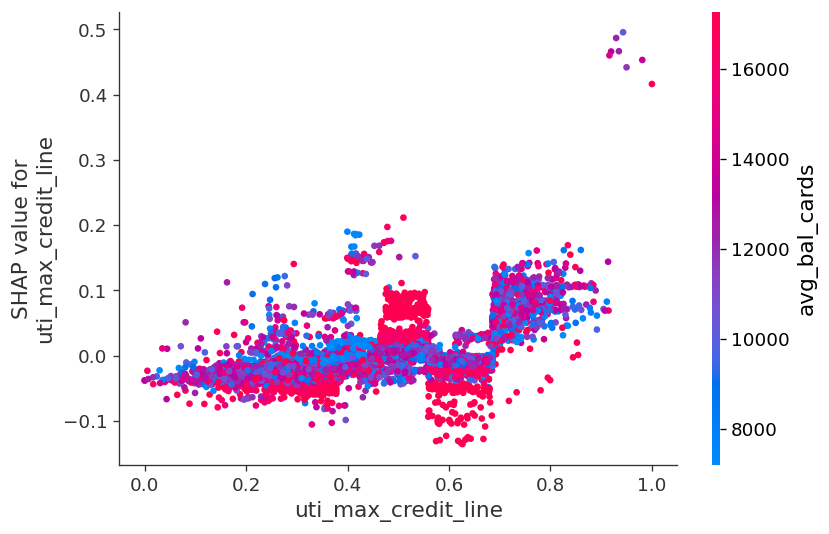

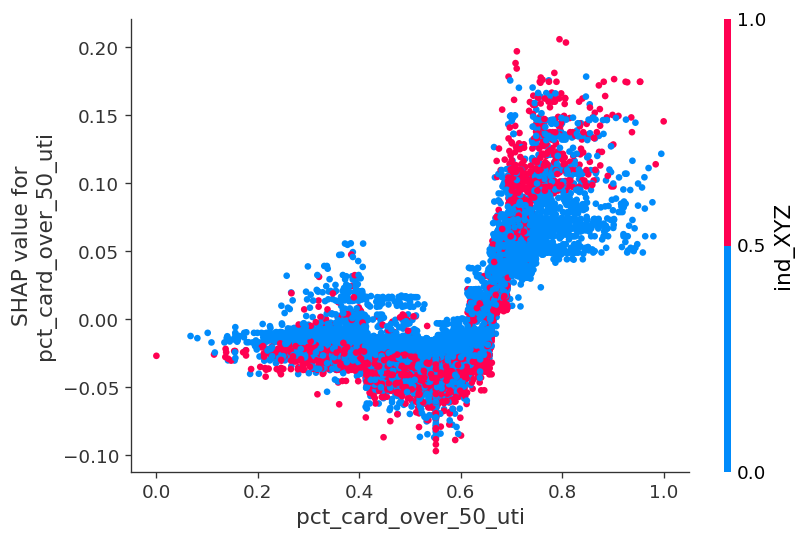

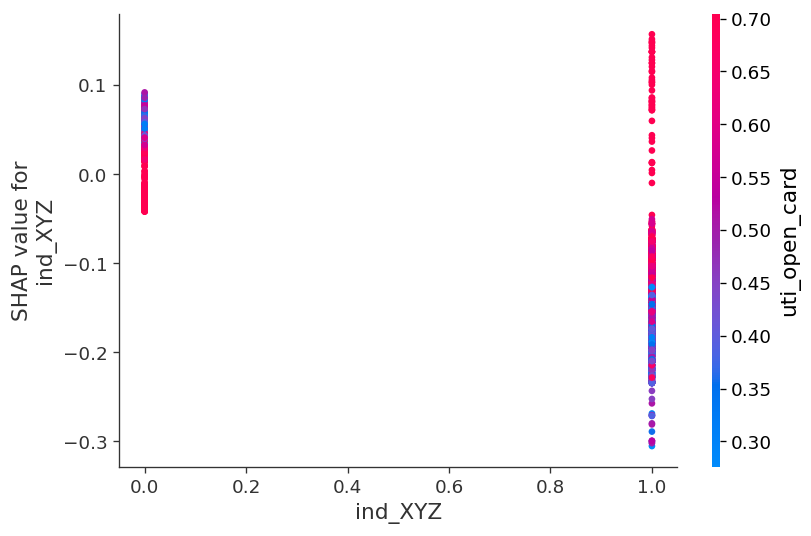

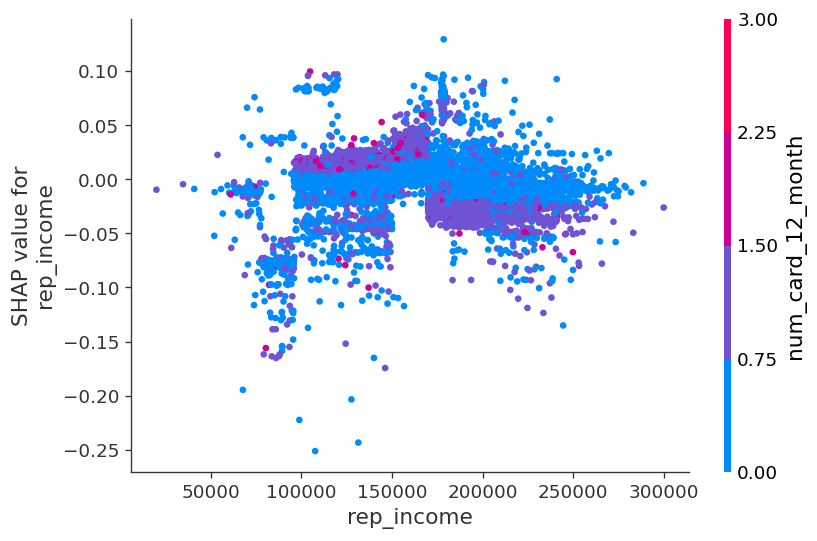

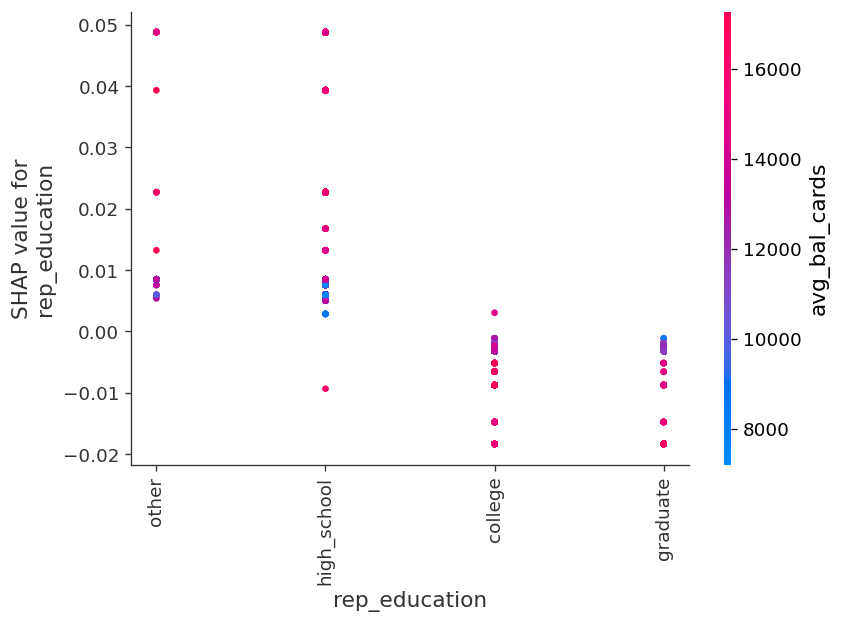

In [32]:
%matplotlib inline
import matplotlib as plt

# pair-wise dependence plots for all the features
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 120 # 200 is really fine, but slower

for name in dftrain.columns:
    shap.dependence_plot(name, shap_values, dftrain, display_features=X_display)

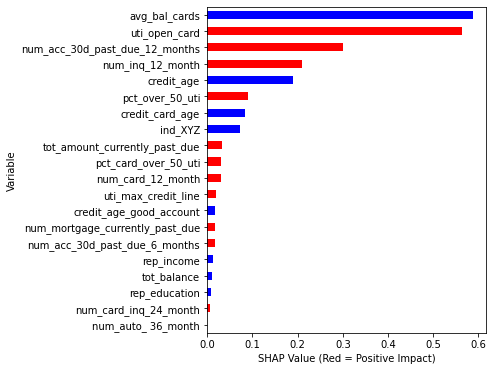

In [30]:
# SHAP Global Interpretation
# Red color represents a negative correlation with the target variable
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,dftrain) 